# CHF Prediction with XGBoost using Short-Term HRV Signals

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, fbeta_score, classification_report, \
                            roc_auc_score, \
                            ConfusionMatrixDisplay, RocCurveDisplay

import datetime
import os
import pprint

In [ ]:
def classification_report_heatmap(cr, label_names, model_name):
    corr_matrix = []

    for label in label_names:
        if cr[label]:
            row = [cr[label]['precision'], cr[label]['recall'], cr[label]['f1-score']]
            corr_matrix.append(row)

    sns.heatmap(
        pd.DataFrame(np.array(corr_matrix), index=label_names, columns=['precision', 'recall', 'f1-score']),
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=1
    )

    plt.title("Classification Report Heatmap\nModel: {0}".format(model_name))
    plt.tight_layout()
    plt.show()

## Load Dataset

In [ ]:
import pathlib

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathlib.Path(par_dir).parent.absolute()

WindowsPath('c:/Users/BIOINFO 9/Documents/Rino/HRV')

In [ ]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# PROJECT_DIR = pathlib.Path(par_dir).parent.absolute()
# PROJECT_DIR = "/content/drive/MyDrive/Projects/HRV"
DATA_DIR = os.path.join(PROJECT_DIR, "dataset/short-term")

In [ ]:
MINS_DIR = "5-min-2-hours-0.5-overlap-normal-beat-with-ectopic-info"
df_nsrdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsrdb.xlsx"))
df_chfdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chfdb.xlsx"))
df_nsr2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsr2db.xlsx"))
df_chf2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chf2db.xlsx"))
df = pd.concat(
    [
        df_nsrdb,
        df_chfdb,
        df_nsr2db,
        df_chf2db
    ],
    axis=0
).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5472 entries, 0 to 5471
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5472 non-null   object 
 1   start_secs              5472 non-null   int64  
 2   end_secs                5472 non-null   int64  
 3   db_source               5472 non-null   object 
 4   age                     5472 non-null   object 
 5   gender                  5472 non-null   object 
 6   fs                      5472 non-null   int64  
 7   signal_length           1584 non-null   float64
 8   recording_time_hours    1584 non-null   float64
 9   recording_time_seconds  1584 non-null   float64
 10  normal_beats            5472 non-null   int64  
 11  abnormal_beats          5472 non-null   int64  
 12  normal_beats_ratio      5472 non-null   float64
 13  rri_length              5472 non-null   int64  
 14  nni_length              5472 non-null   

## Data Cleaning & Filtering

In [ ]:
df_loaded = df.copy()

In [ ]:
map_gender = {"m": 1, "f": 0}

# df = df.dropna()
df = df_loaded.copy()
df = df[(df.age != "?") & (df.gender != "?")]
df = df.replace(["?"], np.nan)
df['age'] = np.array(df['age'], dtype=np.float16)
df['gender'] = df['gender'].map(lambda x: map_gender[x.lower()])
df["record_ids"] = df["id"].map(lambda x: "-".join(x.split("-")[:2]))
df = df[["id", "record_ids"] + df.drop(columns=["id", "record_ids"]).columns.to_list()]
df = df.drop(columns=['tinn'])
df = df.replace([np.inf, -np.inf], np.nan)
# df = df[df['age'] >= 10] # useless since no data with age > 10 in CHFDB, CHF2DB, NSRDB, NSR2DB
df = df[df["normal_beats_ratio"] >= 0.9]

if 'db_source' in df.columns:
    db_source = df['db_source']
    df = df.drop(columns=['db_source'])
drop_columns = ["signal_length", "recording_time_hours", "recording_time_seconds"]
df = df.drop(columns=drop_columns)

df = df.dropna()
df["ratio_sd1_sd2"] = 1 / df["ratio_sd2_sd1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4390 entries, 0 to 4614
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4390 non-null   object 
 1   record_ids          4390 non-null   object 
 2   start_secs          4390 non-null   int64  
 3   end_secs            4390 non-null   int64  
 4   age                 4390 non-null   float16
 5   gender              4390 non-null   int64  
 6   fs                  4390 non-null   int64  
 7   normal_beats        4390 non-null   int64  
 8   abnormal_beats      4390 non-null   int64  
 9   normal_beats_ratio  4390 non-null   float64
 10  rri_length          4390 non-null   int64  
 11  nni_length          4390 non-null   int64  
 12  mean_nni            4390 non-null   float64
 13  sdnn                4390 non-null   float64
 14  sdsd                4390 non-null   float64
 15  nni_50              4390 non-null   int64  
 16  pnni_5

In [ ]:
db_source.value_counts()

nsr2db    2517
nsrdb      780
chfdb      665
chf2db     428
Name: db_source, dtype: int64

## Train-Test Split

In [ ]:
train_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "train_record_ids_7-3_post-filter.csv"))
test_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "test_record_ids_7-3_post-filter.csv"))

df_train = df[
    df["record_ids"].isin(train_record_ids["id"].values)
]

df_test = df[
    df["record_ids"].isin(test_record_ids["id"].values)
]

print(df_train.shape)
print(df_test.shape)

df_train.sample(3)

(3113, 46)
(1277, 46)


,id,record_ids,start_secs,end_secs,age,gender,fs,normal_beats,abnormal_beats,normal_beats_ratio,...,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk,ratio_sd1_sd2
1855,nsr2db-nsr006-4950-5250,nsr2db-nsr006,4950,5250,64.0,1,128,334,3,0.991098,...,23.475473,77.219042,3.289350,3.289350,4.462459,1016.001753,1.231909,Sinus,0,0.304011
1691,nsr2db-nsr003-1950-2250,nsr2db-nsr003,1950,2250,67.0,0,128,336,2,0.994083,...,43.924866,86.242061,1.963400,1.963400,4.782550,677.310478,1.471766,Sinus,0,0.509321
1058,chfdb-chf05-300-600,chfdb-chf05,300,600,59.0,0,250,557,3,0.994643,...,5.942272,17.212573,2.896632,2.896632,3.213918,199.433940,1.828550,NYHA class: III-IV,1,0.345229


In [ ]:
df_inspect = df_test.copy()

In [ ]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

## Feature Selection

In [ ]:
columns_needed = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices + \
                 ['risk']

df_train = df_train[columns_needed]
df_test = df_test[columns_needed]

X_train = df_train.drop(columns=['risk'])
y_train = df_train['risk']
X_test = df_test.drop(columns=['risk'])
y_test = df_test['risk']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3113, 31) (3113,)
(1277, 31) (1277,)


In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

0    2326
1     787
Name: risk, dtype: int64
0    971
1    306
Name: risk, dtype: int64


In [ ]:
pd.set_option('display.max_columns', None)
df_train.sample(3)

,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi,risk
2806,72.0,1,634.133853,29.125392,11.737127,0,0.000000,37,7.838983,11.737127,632.8125,148.43750,0.018509,0.045929,94.819011,108.169014,85.333333,4.405875,68.130212,13.188946,5.165706,83.781256,16.218744,319.954961,238.635803,8.308208,40.342912,0.205940,4.855790,3.729395,783.586863,0
3109,65.0,1,989.226083,50.250527,32.698834,18,6.521739,128,46.376812,32.698944,992.1875,351.56250,0.033055,0.050798,60.810333,71.111111,50.196078,3.102838,1221.423635,134.727186,9.065903,90.065472,9.934528,2125.194072,769.043252,23.163568,67.183927,0.344778,2.900414,4.396191,779.444699,0
2987,70.0,0,743.703358,75.362096,36.939047,6,1.496259,102,25.436409,36.939668,765.6250,519.53125,0.049670,0.101334,81.860332,185.060241,71.111111,12.502149,283.092414,188.870023,1.498874,59.981980,40.018020,1114.968111,643.005675,26.152480,103.319595,0.253122,3.950661,4.635816,1632.722981,0


In [ ]:
pd.reset_option('display.max_columns')

In [ ]:
LABEL_NAMES = ["Healthy", "CHF"]

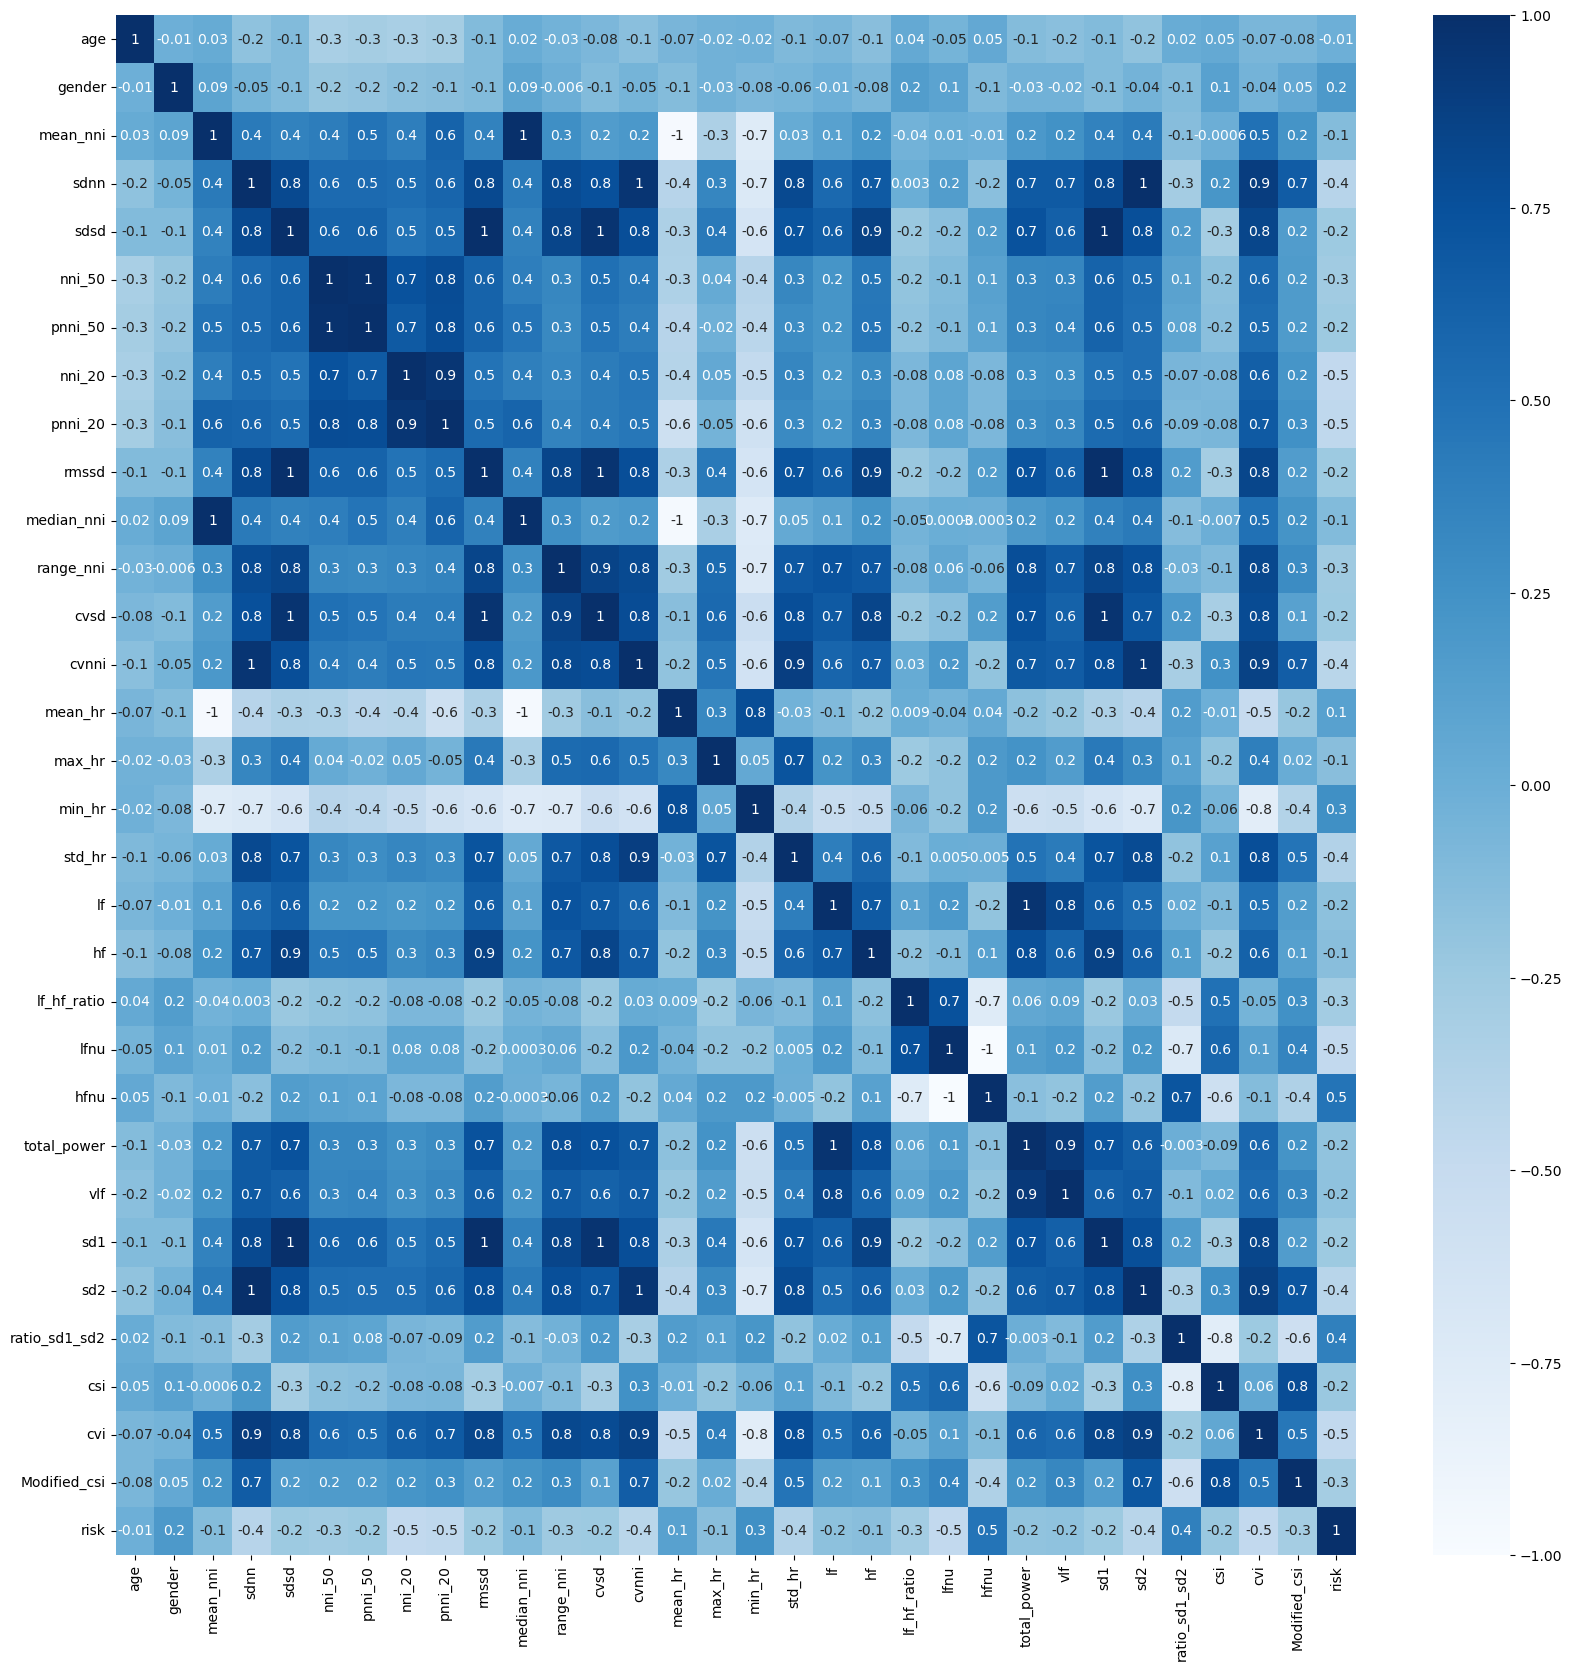

In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)
heatmap = sns.heatmap(df_train.corr(), annot=True, cmap="Blues", fmt='.1g')
plt.rcdefaults()
plt.show()

## XGBoost

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut

from sklearn.metrics import make_scorer

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

In [ ]:
# A parameter grid for XGBoost
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [ ]:
gs = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [ ]:
start = datetime.datetime.now()
gs.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 40 seconds, 212556 microseconds


## Evaluation

In [ ]:
gs.score(X_test, y_test)

0.9537979639780736

TRAIN SET RESULTS
TN, FP, FN, TP       : 2325 1 1 786
Accuracy (Train)     : 0.9993575329264375
Precision (Train)    : 0.9993575329264375
Sensitivity (Train)  : 0.9987293519695044
Specificity (Train)  : 0.9995700773860705
F1-Score (Train)     : 0.9993575329264375
AUC Score (Train)    : 0.9991497146777875
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




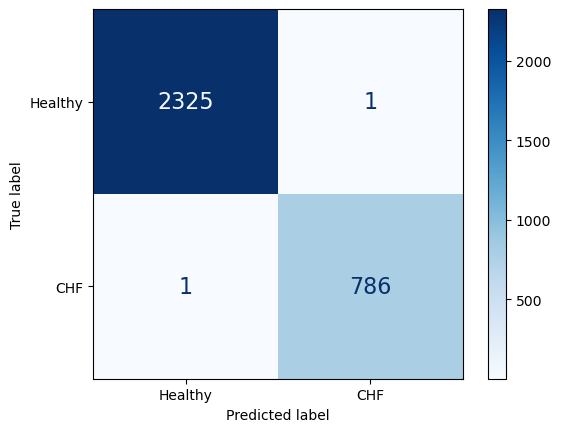


TEST SET RESULTS
TN, FP, FN, TP       : 932 39 20 286
Accuracy             : 0.9537979639780736
Precision            : 0.9552708225028461
Sensitivity          : 0.934640522875817
Specificity          : 0.9598352214212152
F1-Score             : 0.9542653100425488
AUC Score            : 0.9472378721485161
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       971
         CHF       0.88      0.93      0.91       306

    accuracy                           0.95      1277
   macro avg       0.93      0.95      0.94      1277
weighted avg       0.96      0.95      0.95      1277




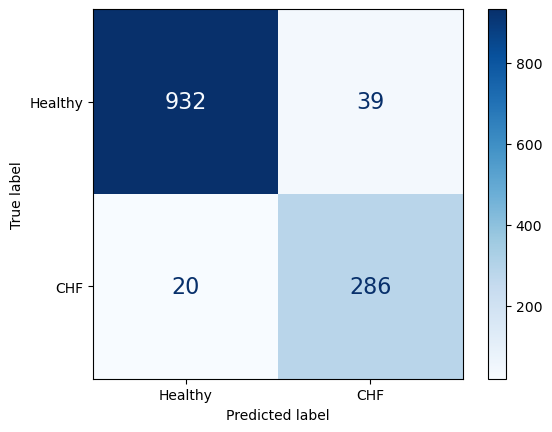

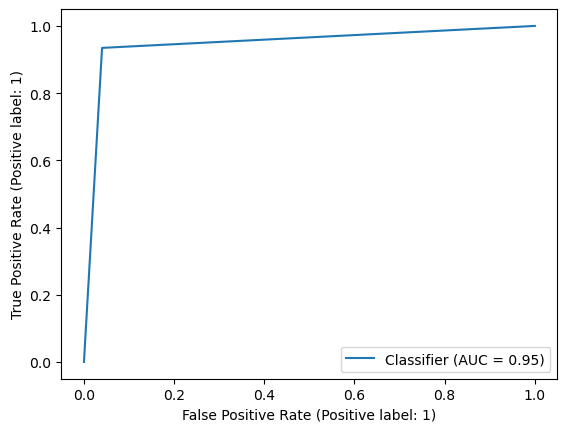

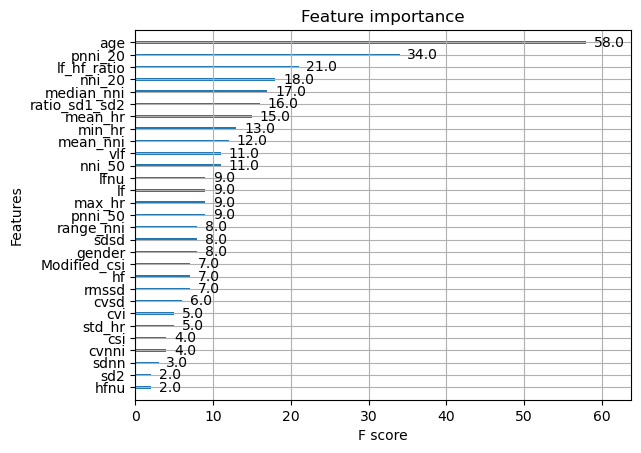

In [ ]:
y_pred_train = gs.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs.best_estimator_)
plt.show()

In [ ]:
print("Best Params")
pprint.pprint(gs.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.8}



### Sensitivity

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall",
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 44 seconds, 82441 microseconds


In [ ]:
gs_sensitivity.score(X_test, y_test)

0.9771241830065359

In [ ]:
def evaluate(gs: GridSearch):
    y_pred_train = gs.best_estimator_.predict(X_train)
    AVERAGE = 'weighted'
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
    f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
    sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
    specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
    auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
    print("TRAIN SET RESULTS")
    print("TN, FP, FN, TP       :", tn, fp, fn, tp)
    print("Accuracy (Train)     :", accuracy_train)
    print("Precision (Train)    :", precision_train)
    print("Sensitivity (Train)  :", sensitivity_train)
    print("Specificity (Train)  :", specificity_train)
    print("F1-Score (Train)     :", f1_train)
    print("AUC Score (Train)    :", auc_train)
    print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
    print()
    ConfusionMatrixDisplay.from_predictions(
        y_train, y_pred_train,
        display_labels=LABEL_NAMES,
        cmap=plt.cm.Blues,
        text_kw={
            "fontsize": 16,
        },
    )
    plt.show()
    print()

    y_pred = gs.best_estimator_.predict(X_test)
    AVERAGE = 'weighted'
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    num_positives = len(np.where(y_test == 1)[0])
    num_negatives = len(np.where(y_test == 0)[0])
    precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
    print("TEST SET RESULTS")
    print("TN, FP, FN, TP       :", tn, fp, fn, tp)
    print("Accuracy             :", accuracy)
    print("Precision            :", precision)
    print("Sensitivity          :", sensitivity)
    print("Specificity          :", specificity)
    print("F1-Score             :", f1)
    print("AUC Score            :", auc)
    print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
    print()
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=LABEL_NAMES,
        cmap=plt.cm.Blues,
        text_kw={
            "fontsize": 16,
        },
    )
    plt.show()

    print()
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print()
    xgboost.plot_importance(gs.best_estimator_)
    plt.show()

TRAIN SET RESULTS
TN, FP, FN, TP       : 2323 3 3 784
Accuracy (Train)     : 0.9980725987793125
Precision (Train)    : 0.9980725987793125
Sensitivity (Train)  : 0.9961880559085133
Specificity (Train)  : 0.9987102321582115
F1-Score (Train)     : 0.9980725987793125
AUC Score (Train)    : 0.9974491440333625
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




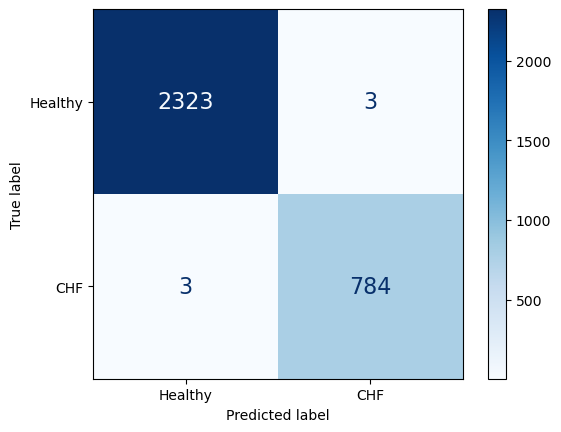


TEST SET RESULTS
TN, FP, FN, TP       : 935 36 7 299
Accuracy             : 0.966327329678935
Precision            : 0.968598996845747
Sensitivity          : 0.9771241830065359
Specificity          : 0.9629248197734295
F1-Score             : 0.9668338066139072
AUC Score            : 0.9700245013899828
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.98       971
         CHF       0.89      0.98      0.93       306

    accuracy                           0.97      1277
   macro avg       0.94      0.97      0.96      1277
weighted avg       0.97      0.97      0.97      1277




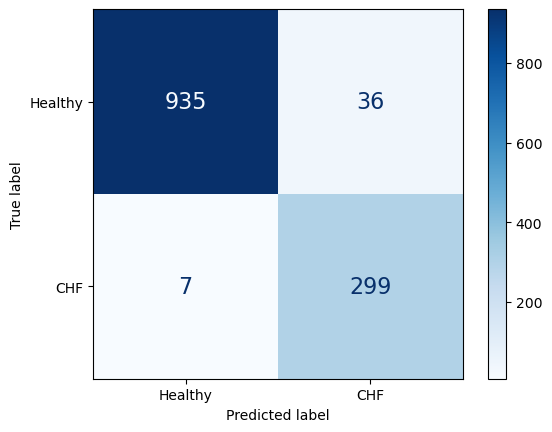

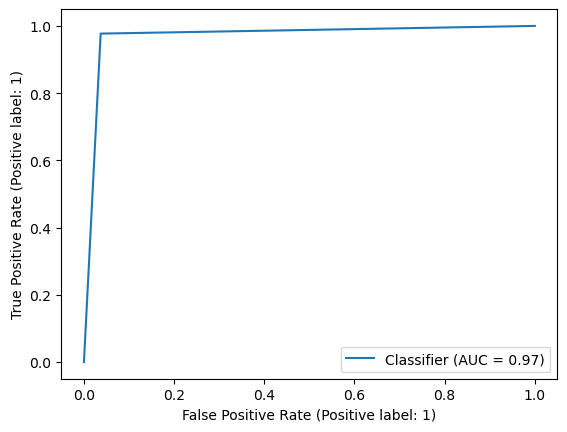

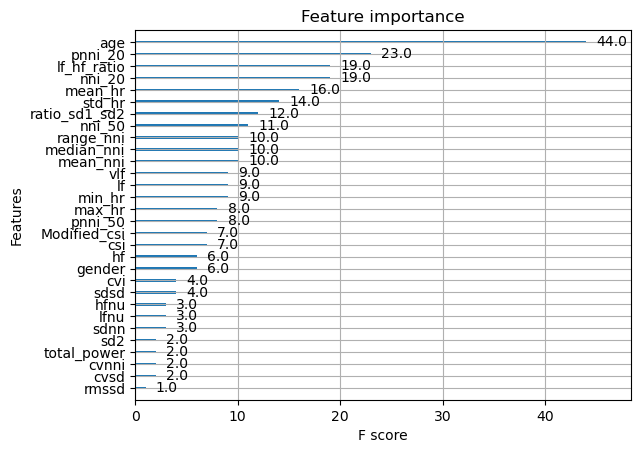

In [ ]:
y_pred_train = gs_sensitivity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_sensitivity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity.best_estimator_)
plt.show()

In [ ]:
print("Best Params")
pprint.pprint(gs_sensitivity.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 150,
 'subsample': 0.8}



### Specificity

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

specificity = make_scorer(recall_score, pos_label=0)

gs_specificity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring=specificity,
)

In [ ]:
start = datetime.datetime.now()
gs_specificity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 44 seconds, 944540 microseconds


In [ ]:
gs_specificity.score(X_test, y_test)

0.9711637487126673

TRAIN SET RESULTS
TN, FP, FN, TP       : 2326 0 0 787
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




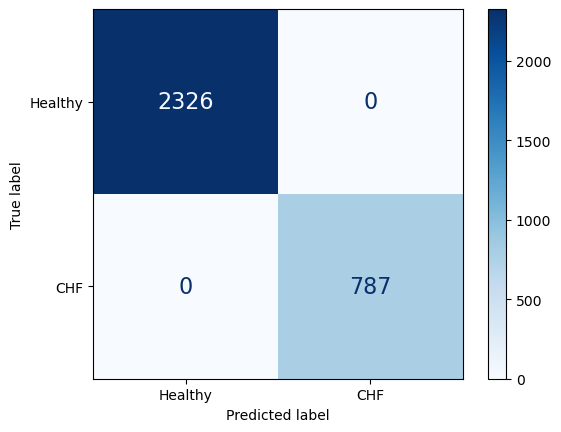


TEST SET RESULTS
TN, FP, FN, TP       : 943 28 21 285
Accuracy             : 0.961628817541112
Precision            : 0.9619997716965631
Sensitivity          : 0.9313725490196079
Specificity          : 0.9711637487126673
F1-Score             : 0.9617763737532284
AUC Score            : 0.9512681488661375
              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.97       971
         CHF       0.91      0.93      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.95      0.95      1277
weighted avg       0.96      0.96      0.96      1277




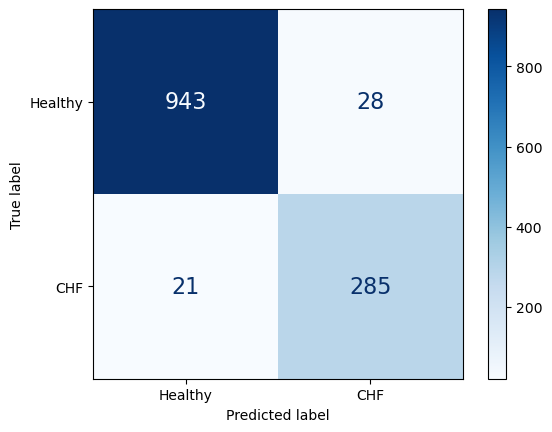

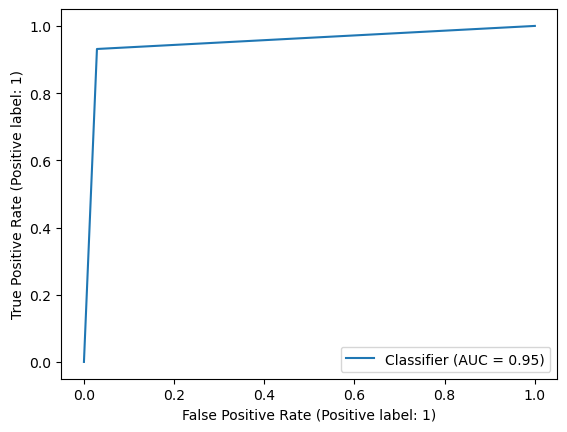

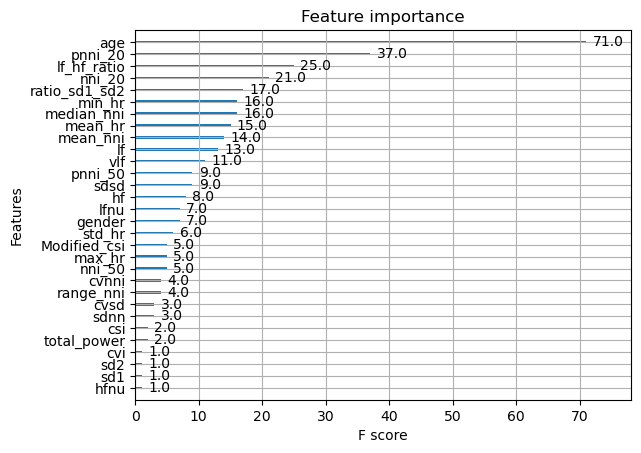

In [ ]:
y_pred_train = gs_specificity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_specificity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_specificity.best_estimator_)
plt.show()

In [ ]:
print("Best Params")
pprint.pprint(gs_specificity.best_params_)
print()

## Save model

In [ ]:
import pickle
# Ref: https://stackoverflow.com/questions/57730192/how-to-save-gridsearchcv-xgboost-model

# Dictionary of best parameters
best_pars = gs.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = gs.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))

In [ ]:
# Ref: https://stackoverflow.com/a/64823806

import joblib

#save your model or results
gs_filename = f"xgb-gs-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs, os.path.join(MODEL_DIR, gs_filename))

#load your model for further usage
gs_best = joblib.load(os.path.join(MODEL_DIR, gs_filename))


In [ ]:
gs_best.best_estimator_.score(X_test, y_test), gs_best.best_params_

### Sensitivity

In [ ]:
import pickle

# Best XGB model that was found based on the metric score you specify
best_model = gs_sensitivity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-sensitivity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_sensitivity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_sensitivity_filename = f"xgb-gs_sensitivity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_sensitivity, os.path.join(MODEL_DIR, gs_sensitivity_filename))

#load your model for further usage
gs_sensitivity_best = joblib.load(os.path.join(MODEL_DIR, gs_sensitivity_filename))
print(gs_sensitivity_best.best_params_)

### Specificity

In [ ]:
import pickle
import joblib

# Best XGB model that was found based on the metric score you specify
best_model = gs_specificity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-specificity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_specificity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_specificity_filename = f"xgb-gs_specificity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_specificity, os.path.join(MODEL_DIR, gs_specificity_filename))

#load your model for further usage
gs_specificity_best = joblib.load(os.path.join(MODEL_DIR, gs_specificity_filename))
print(gs_specificity_best.best_params_)

## Feature Selection

In [ ]:
# ref: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
importance_score = gs.best_estimator_.get_booster().get_score(importance_type='weight')
top_importance_score = {k: v for k, v in sorted(importance_score.items(), key=lambda item: item[1], reverse=True)}

top_5_features = []
top_10_features = []
top_15_features = []
for k, v in top_importance_score.items():
    if len(top_5_features) < 5:
        top_5_features.append(k)
    if len(top_10_features) < 10:
        top_10_features.append(k)
    if len(top_15_features) < 15:
        top_15_features.append(k)

### ReFit - Top 5

In [ ]:
X_top_5_train = X_train[top_5_features]
X_top_5_test = X_test[top_5_features]

print(X_top_5_train.shape, y_train.shape)
print(X_top_5_test.shape, y_test.shape)

(3113, 5) (3113,)
(1277, 5) (1277,)


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_5 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity_top_5.fit(X_top_5_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_5_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 5)
Fitting time: 0 hours, 3 minutes, 1 seconds, 137547 microseconds


In [ ]:
gs_sensitivity_top_5.score(X_top_5_test, y_test)

0.9019607843137255

TRAIN SET RESULTS
TN, FP, FN, TP       : 2317 9 20 767
Accuracy (Train)     : 0.9906842274333441
Precision (Train)    : 0.9906734855328929
Sensitivity (Train)  : 0.974587039390089
Specificity (Train)  : 0.9961306964746346
F1-Score (Train)     : 0.9906624343405996
AUC Score (Train)    : 0.9853588679323618
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99      2326
         CHF       0.99      0.97      0.98       787

    accuracy                           0.99      3113
   macro avg       0.99      0.99      0.99      3113
weighted avg       0.99      0.99      0.99      3113




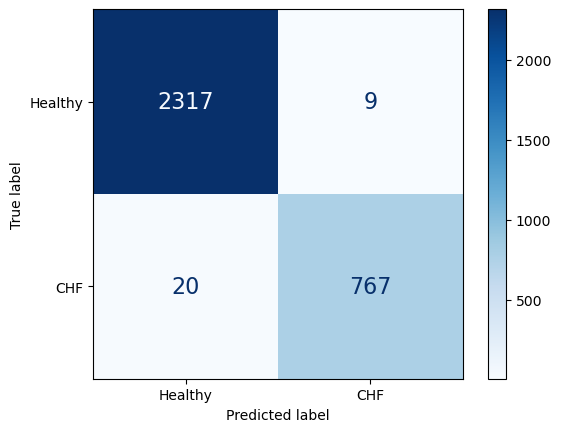


TEST SET RESULTS
TN, FP, FN, TP       : 900 71 30 276
Accuracy             : 0.9209083790133125
Precision            : 0.926442026896001
Sensitivity          : 0.9019607843137255
Specificity          : 0.9268795056642637
F1-Score             : 0.9225384391423197
AUC Score            : 0.9144201449889946
              precision    recall  f1-score   support

     Healthy       0.97      0.93      0.95       971
         CHF       0.80      0.90      0.85       306

    accuracy                           0.92      1277
   macro avg       0.88      0.91      0.90      1277
weighted avg       0.93      0.92      0.92      1277




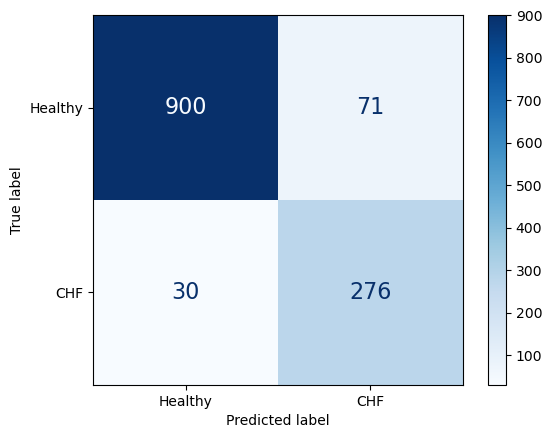

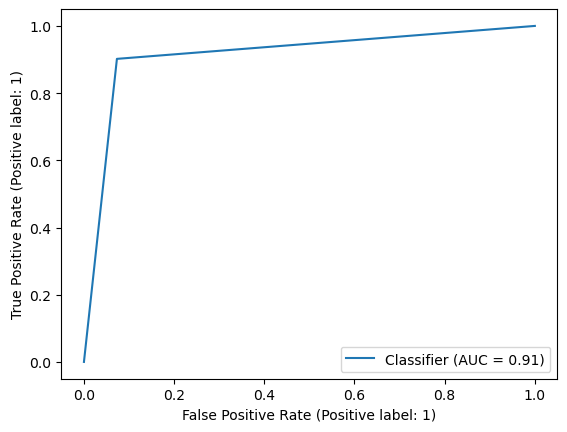

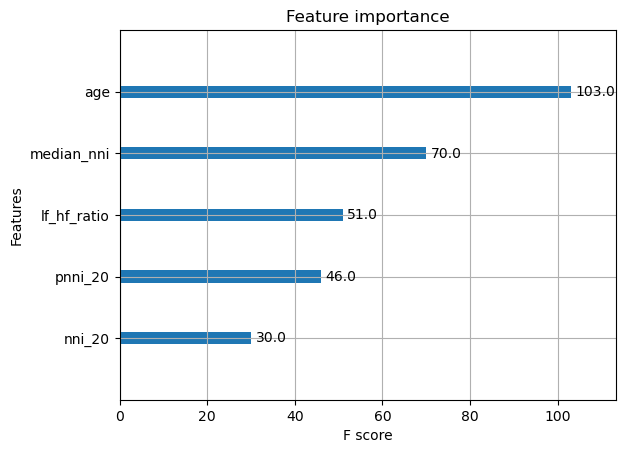

In [ ]:
y_pred_train = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_5.best_estimator_)
plt.show()

### ReFit - Top 10

In [ ]:
X_top_10_train = X_train[top_10_features]
X_top_10_test = X_test[top_10_features]

print(X_top_10_train.shape, y_train.shape)
print(X_top_10_test.shape, y_test.shape)

(3113, 10) (3113,)
(1277, 10) (1277,)


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_10 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity_top_10.fit(X_top_10_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_10_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 10)
Fitting time: 0 hours, 4 minutes, 9 seconds, 945820 microseconds


In [ ]:
gs_sensitivity_top_10.score(X_top_10_test, y_test)

0.93265465935787

TRAIN SET RESULTS
TN, FP, FN, TP       : 2325 1 5 782
Accuracy (Train)     : 0.9980725987793125
Precision (Train)    : 0.9980737151089478
Sensitivity (Train)  : 0.9936467598475223
Specificity (Train)  : 0.9995700773860705
F1-Score (Train)     : 0.9980709714126198
AUC Score (Train)    : 0.9966084186167964
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      0.99      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




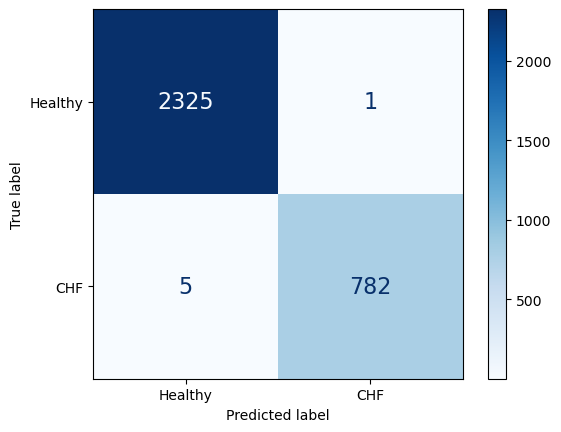


TEST SET RESULTS
TN, FP, FN, TP       : 916 55 31 275
Accuracy             : 0.93265465935787
Precision            : 0.9351717784968234
Sensitivity          : 0.8986928104575164
Specificity          : 0.9433573635427395
F1-Score             : 0.9335039788800061
AUC Score            : 0.9210250870001279
              precision    recall  f1-score   support

     Healthy       0.97      0.94      0.96       971
         CHF       0.83      0.90      0.86       306

    accuracy                           0.93      1277
   macro avg       0.90      0.92      0.91      1277
weighted avg       0.94      0.93      0.93      1277




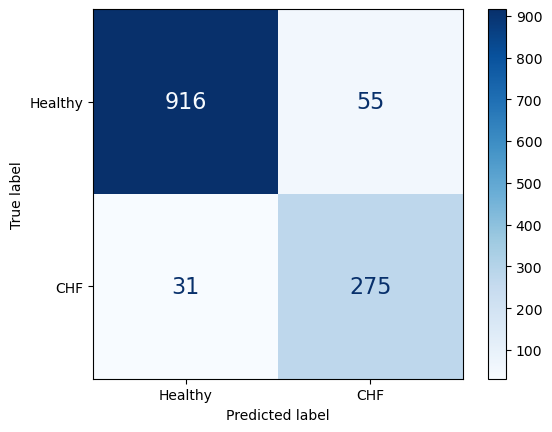

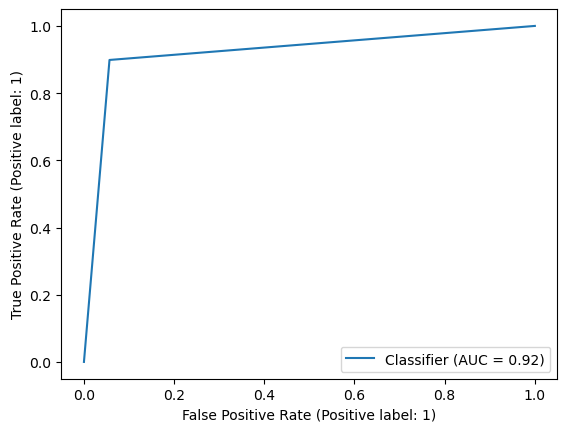

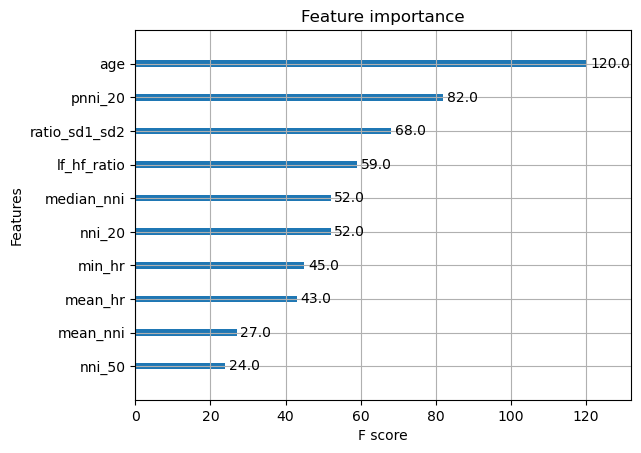

In [ ]:
y_pred_train = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_10.best_estimator_)
plt.show()

### ReFit - Top 15

In [ ]:
X_top_15_train = X_train[top_15_features]
X_top_15_test = X_test[top_15_features]

print(X_top_15_train.shape, y_train.shape)
print(X_top_15_test.shape, y_test.shape)

(3113, 15) (3113,)
(1277, 15) (1277,)


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_15 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity_top_15.fit(X_top_15_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_15_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 15)
Fitting time: 0 hours, 5 minutes, 24 seconds, 88940 microseconds


In [ ]:
gs_sensitivity_top_15.score(X_top_15_test, y_test)

0.9537979639780736

TRAIN SET RESULTS
TN, FP, FN, TP       : 2322 4 5 782
Accuracy (Train)     : 0.9971088981689689
Precision (Train)    : 0.9971079536237635
Sensitivity (Train)  : 0.9936467598475223
Specificity (Train)  : 0.998280309544282
F1-Score (Train)     : 0.9971082898626408
AUC Score (Train)    : 0.9959635346959022
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       0.99      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




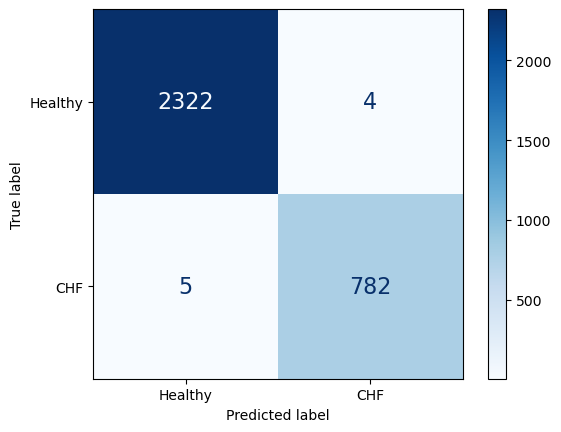


TEST SET RESULTS
TN, FP, FN, TP       : 926 45 14 292
Accuracy             : 0.9537979639780736
Precision            : 0.9566779669128516
Sensitivity          : 0.954248366013072
Specificity          : 0.9536560247167868
F1-Score             : 0.954536957116737
AUC Score            : 0.9539521953649294
              precision    recall  f1-score   support

     Healthy       0.99      0.95      0.97       971
         CHF       0.87      0.95      0.91       306

    accuracy                           0.95      1277
   macro avg       0.93      0.95      0.94      1277
weighted avg       0.96      0.95      0.95      1277




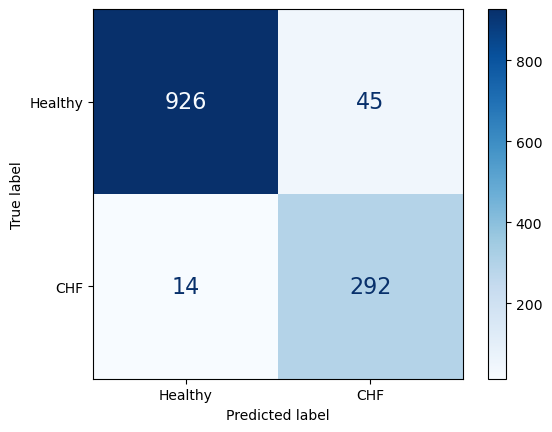

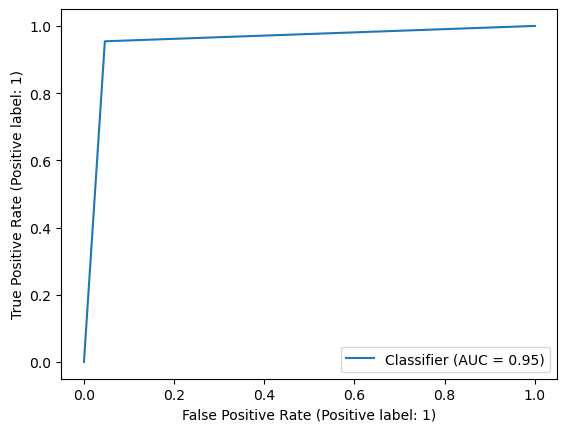

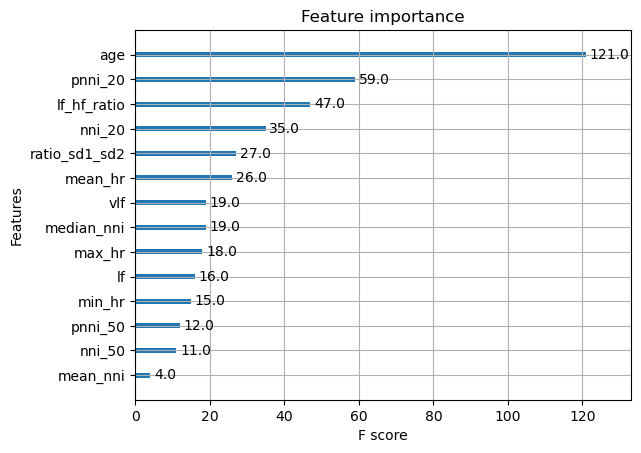

In [ ]:
y_pred_train = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_15.best_estimator_)
plt.show()

## Feature Reduction

### Remove Age

In [ ]:
columns_wo_age = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_age.remove("age")

In [ ]:
X_wo_age_train = X_train[columns_wo_age]
X_wo_age_test = X_test[columns_wo_age]

print(X_wo_age_train.shape, y_train.shape)
print(X_wo_age_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_age_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 30) (3113,)
(1277, 30) (1277,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
3961,1,828.146641,79.453224,62.111498,124,34.444444,258,71.666667,62.111559,820.3125,664.062500,0.075001,0.095941,73.192712,144.905660,55.652174,8.177905,1960.202855,947.298894,2.069255,67.418802,32.581198,4346.731598,1439.229850,43.980588,103.398925,0.425349,2.351013,4.861897,972.368773
4500,1,771.219889,90.725542,82.527815,21,5.483029,86,22.454308,82.527878,781.2500,924.804688,0.107010,0.117639,79.247993,170.666667,47.008416,13.667094,2439.614505,1505.032321,1.620972,61.846209,38.153791,5288.627377,1343.980551,58.432310,114.227463,0.511543,1.954868,5.028544,893.198523
2519,0,518.747297,25.594193,16.880911,5,0.866551,110,19.064125,16.881107,515.6250,195.312500,0.032542,0.049338,115.938672,139.636364,96.000000,5.604990,211.976442,41.354754,5.125806,83.675617,16.324383,418.369052,165.037857,11.946964,34.167170,0.349662,2.859904,3.814987,390.859293


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_age = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)


In [ ]:
start = datetime.datetime.now()
gs_sensitivity_wo_age.fit(X_wo_age_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_age_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 30)
Fitting time: 0 hours, 12 minutes, 3 seconds, 107350 microseconds


In [ ]:
gs_sensitivity_wo_age.score(X_wo_age_test, y_test)

0.869281045751634

TRAIN SET RESULTS
TN, FP, FN, TP       : 2322 4 10 777
Accuracy (Train)     : 0.9955027304850627
Precision (Train)    : 0.9955011240457585
Sensitivity (Train)  : 0.9872935196950444
Specificity (Train)  : 0.998280309544282
F1-Score (Train)     : 0.9954970224963375
AUC Score (Train)    : 0.9927869146196633
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       0.99      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      0.99      0.99      3113
weighted avg       1.00      1.00      1.00      3113




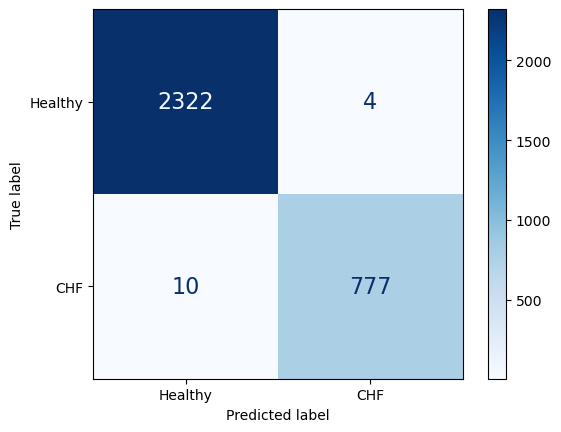


TEST SET RESULTS
TN, FP, FN, TP       : 925 46 40 266
Accuracy             : 0.93265465935787
Precision            : 0.9331526317317173
Sensitivity          : 0.869281045751634
Specificity          : 0.952626158599382
F1-Score             : 0.9328772210378584
AUC Score            : 0.910953602175508
              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.96       971
         CHF       0.85      0.87      0.86       306

    accuracy                           0.93      1277
   macro avg       0.91      0.91      0.91      1277
weighted avg       0.93      0.93      0.93      1277




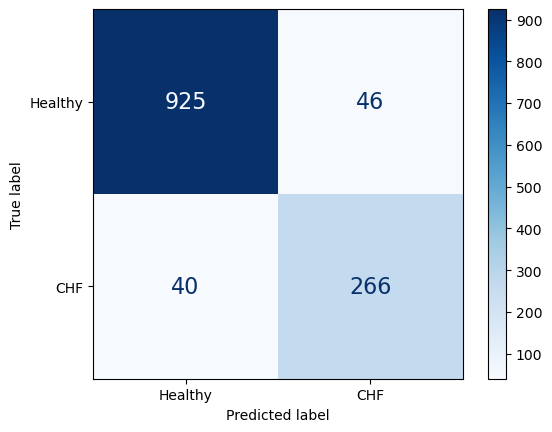

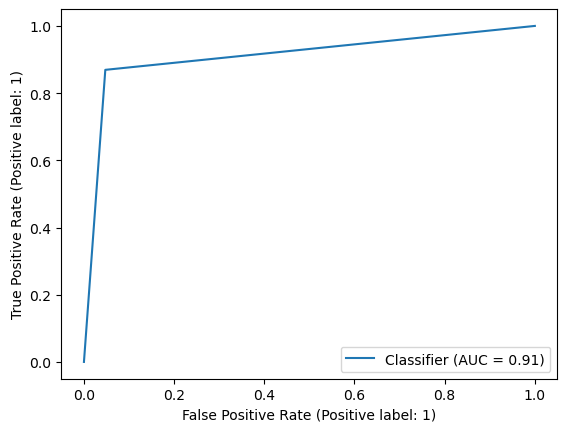

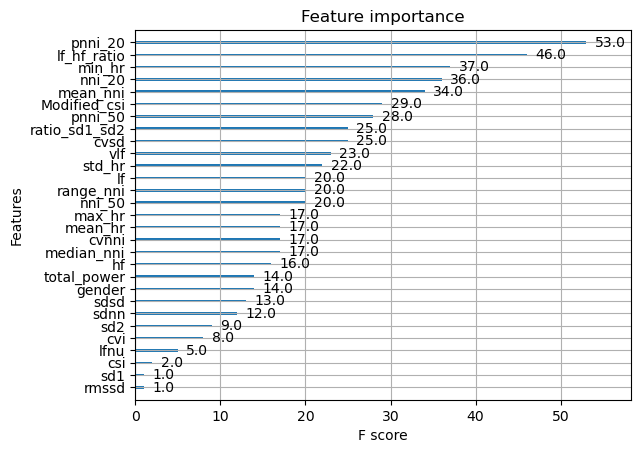

In [ ]:
y_pred_train = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_age.best_estimator_)
plt.show()

### Remove LF/HF

In [ ]:
columns_wo_lf_hf_ratio = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_lf_hf_ratio.remove("lf_hf_ratio")

In [ ]:
X_wo_lf_hf_ratio_train = X_train[columns_wo_lf_hf_ratio]
X_wo_lf_hf_ratio_test = X_test[columns_wo_lf_hf_ratio]

print(X_wo_lf_hf_ratio_train.shape, y_train.shape)
print(X_wo_lf_hf_ratio_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_lf_hf_ratio_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 30) (3113,)
(1277, 30) (1277,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
4377,38.0,0,577.598315,7.444941,9.362335,1,0.28169,8,2.253521,9.363990,578.1250,85.9375,0.016212,0.012889,103.896186,118.153846,101.052632,1.382757,2.104072,2.172035,49.205319,50.794681,13.561473,9.285366,6.629514,8.179476,0.810506,1.233797,2.938327,40.367260
3136,65.0,1,920.366044,61.916805,20.209575,3,0.93750,97,30.312500,20.209575,937.5000,281.2500,0.021958,0.067274,65.509931,80.842105,58.625954,4.758594,427.159674,64.055252,86.959832,13.040168,1386.517069,895.302143,14.312709,86.385924,0.165683,6.035610,4.296285,2085.566902
1971,66.0,1,798.713235,116.731613,13.569865,0,0.00000,49,13.136729,13.591976,773.4375,343.7500,0.017017,0.146150,76.768408,96.000000,61.935484,11.333793,251.503078,27.550766,90.127079,9.872921,1119.852028,840.798184,9.608232,164.803583,0.058301,17.152332,4.403730,11307.063314


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_lf_hf_ratio = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity_wo_lf_hf_ratio.fit(X_wo_lf_hf_ratio_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_lf_hf_ratio_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 30)
Fitting time: 0 hours, 9 minutes, 37 seconds, 541746 microseconds


In [ ]:
gs_sensitivity_wo_lf_hf_ratio.score(X_wo_lf_hf_ratio_test, y_test)

0.954248366013072

TRAIN SET RESULTS
TN, FP, FN, TP       : 2323 3 1 786
Accuracy (Train)     : 0.9987150658528751
Precision (Train)    : 0.9987172322446319
Sensitivity (Train)  : 0.9987293519695044
Specificity (Train)  : 0.9987102321582115
F1-Score (Train)     : 0.9987156048364959
AUC Score (Train)    : 0.998719792063858
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




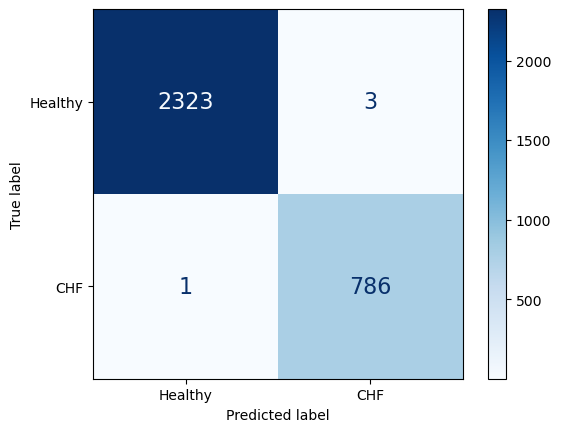


TEST SET RESULTS
TN, FP, FN, TP       : 942 29 14 292
Accuracy             : 0.966327329678935
Precision            : 0.9672165034572822
Sensitivity          : 0.954248366013072
Specificity          : 0.9701338825952626
F1-Score             : 0.9665990567568569
AUC Score            : 0.9621911243041673
              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       971
         CHF       0.91      0.95      0.93       306

    accuracy                           0.97      1277
   macro avg       0.95      0.96      0.95      1277
weighted avg       0.97      0.97      0.97      1277




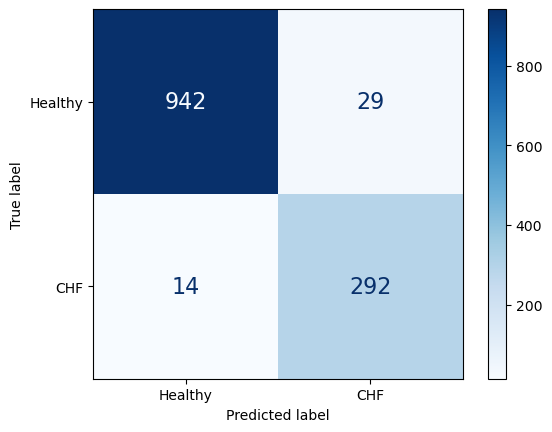

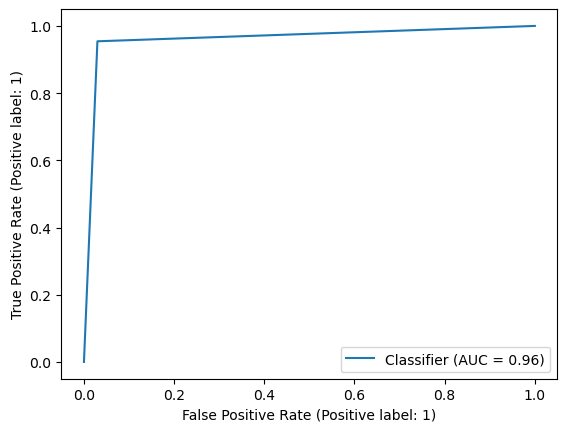

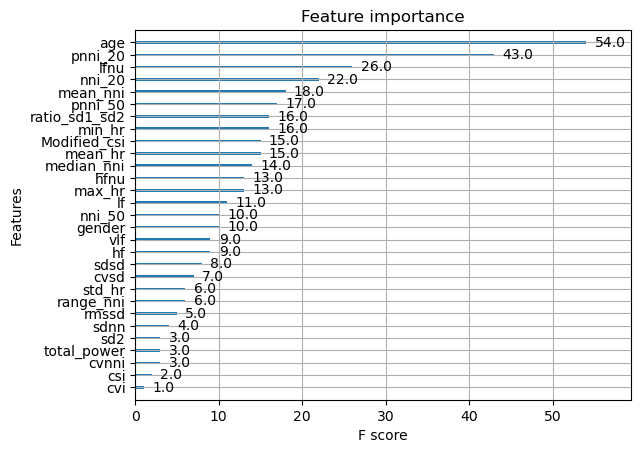

In [ ]:
y_pred_train = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_lf_hf_ratio.best_estimator_)
plt.show()

### Remove NNI_20

In [ ]:
columns_wo_nni_20 = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_nni_20.remove("nni_20")

In [ ]:
X_wo_nni_20_train = X_train[columns_wo_nni_20]
X_wo_nni_20_test = X_test[columns_wo_nni_20]

print(X_wo_nni_20_train.shape, y_train.shape)
print(X_wo_nni_20_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_nni_20_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 30) (3113,)
(1277, 30) (1277,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
338,32.0,0,824.380165,55.237521,34.408506,51,14.088398,52.762431,34.408533,828.1250,273.43750,0.041739,0.067005,73.116495,88.275862,62.950820,5.018182,1492.379021,340.486701,4.383076,81.423260,18.576740,2346.014505,513.148784,24.364163,74.220987,0.328265,3.046318,4.461398,904.402898
4542,65.0,1,634.567002,21.461012,21.852353,2,0.424628,2.760085,21.852359,632.8125,335.93750,0.034437,0.033820,94.747681,182.857143,90.352941,5.860278,51.039755,102.428512,0.498296,33.257530,66.742470,178.097483,24.629216,15.468376,26.112821,0.592367,1.688142,3.810418,176.328635
4491,62.0,1,765.825321,52.201475,53.149702,8,2.056555,15.681234,53.149717,765.6250,839.84375,0.069402,0.068164,78.798621,156.734694,49.073482,7.358272,558.996672,865.311804,0.646006,39.246882,60.753118,1843.365869,419.057394,37.630915,63.513009,0.592491,1.687788,4.582527,428.786001


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_nni_20 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity_wo_nni_20.fit(X_wo_nni_20_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_nni_20_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 30)
Fitting time: 0 hours, 9 minutes, 46 seconds, 411626 microseconds


In [ ]:
gs_sensitivity_wo_nni_20.score(X_wo_nni_20_test, y_test)

0.9607843137254902

TRAIN SET RESULTS
TN, FP, FN, TP       : 2322 4 6 781
Accuracy (Train)     : 0.9967876646321876
Precision (Train)    : 0.9967860467575883
Sensitivity (Train)  : 0.9923761118170267
Specificity (Train)  : 0.998280309544282
F1-Score (Train)     : 0.996786311392915
AUC Score (Train)    : 0.9953282106806544
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       0.99      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




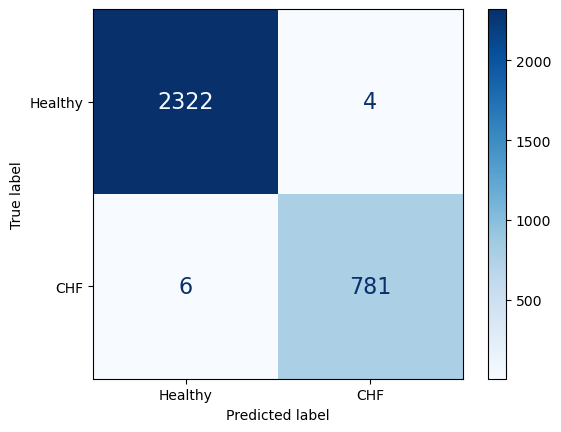


TEST SET RESULTS
TN, FP, FN, TP       : 942 29 12 294
Accuracy             : 0.9678935003915426
Precision            : 0.9689212837208192
Sensitivity          : 0.9607843137254902
Specificity          : 0.9701338825952626
F1-Score             : 0.968185603048563
AUC Score            : 0.9654590981603763
              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       971
         CHF       0.91      0.96      0.93       306

    accuracy                           0.97      1277
   macro avg       0.95      0.97      0.96      1277
weighted avg       0.97      0.97      0.97      1277




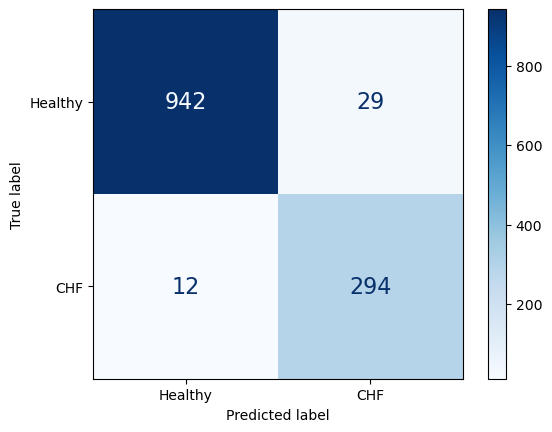

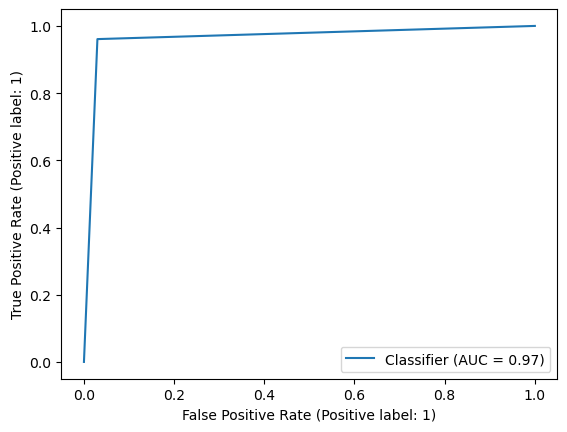

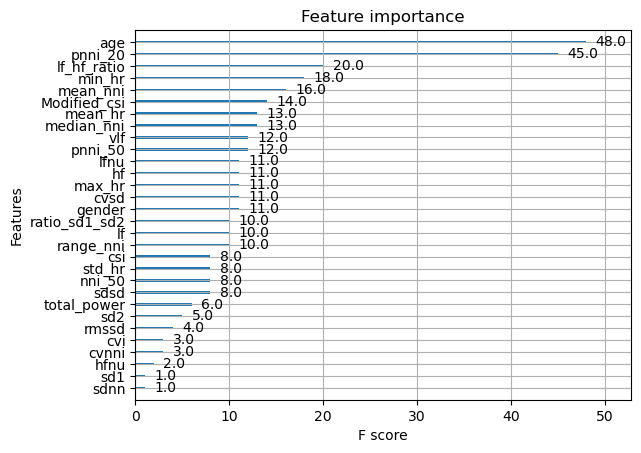

In [ ]:
y_pred_train = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_nni_20.best_estimator_)
plt.show()

### Remove Age, LF/HF, NNI_20

In [ ]:
columns_wo_all = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_all.remove("age")
columns_wo_all.remove("lf_hf_ratio")
columns_wo_all.remove("nni_20")

In [ ]:
X_wo_all_train = X_train[columns_wo_all]
X_wo_all_test = X_test[columns_wo_all]

print(X_wo_all_train.shape, y_train.shape)
print(X_wo_all_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_all_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 28) (3113,)
(1277, 28) (1277,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
3097,1,980.755208,75.274818,25.729796,13,4.347826,38.127090,25.734585,984.3750,328.1250,0.02624,0.076752,61.537741,71.775701,51.543624,4.721363,724.056166,78.811442,90.183756,9.816244,2732.430444,1929.562837,18.224214,104.883146,0.173757,5.755153,4.485474,2414.474350
802,0,724.954600,62.409277,34.637176,51,12.378641,50.970874,34.638344,710.9375,304.6875,0.04778,0.086087,83.349930,97.215190,65.084746,6.850198,1788.894429,612.052776,74.507862,25.492138,3915.829327,1514.882122,24.521960,84.785077,0.289225,3.457516,4.521995,1172.583159
812,0,737.107451,61.145053,33.235343,52,12.839506,44.197531,33.236440,726.5625,343.7500,0.04509,0.082953,81.938459,97.215190,62.439024,6.539535,815.623641,613.420969,57.074750,42.925250,2588.591954,1159.547344,23.530004,83.209218,0.282781,3.536303,4.495913,1177.011954


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_all = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [ ]:
start = datetime.datetime.now()
gs_sensitivity_wo_all.fit(X_wo_all_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_all_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 28)
Fitting time: 0 hours, 11 minutes, 27 seconds, 228213 microseconds


In [ ]:
gs_sensitivity_wo_all.score(X_wo_all_test, y_test)

0.8496732026143791

TRAIN SET RESULTS
TN, FP, FN, TP       : 2323 3 10 777
Accuracy (Train)     : 0.9958239640218439
Precision (Train)    : 0.9958249538096382
Sensitivity (Train)  : 0.9872935196950444
Specificity (Train)  : 0.9987102321582115
F1-Score (Train)     : 0.9958177737452543
AUC Score (Train)    : 0.993001875926628
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      0.99      0.99      3113
weighted avg       1.00      1.00      1.00      3113




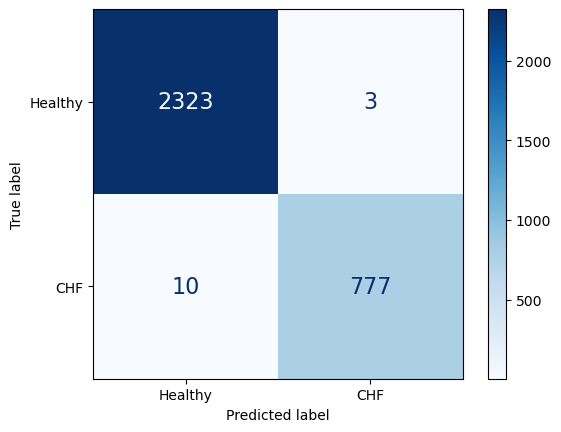


TEST SET RESULTS
TN, FP, FN, TP       : 927 44 46 260
Accuracy             : 0.9295223179326546
Precision            : 0.9293696783436765
Sensitivity          : 0.8496732026143791
Specificity          : 0.9546858908341915
F1-Score             : 0.9294430347006184
AUC Score            : 0.9021795467242854
              precision    recall  f1-score   support

     Healthy       0.95      0.95      0.95       971
         CHF       0.86      0.85      0.85       306

    accuracy                           0.93      1277
   macro avg       0.90      0.90      0.90      1277
weighted avg       0.93      0.93      0.93      1277




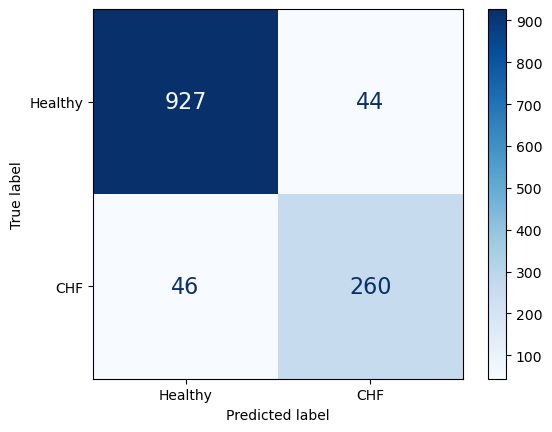

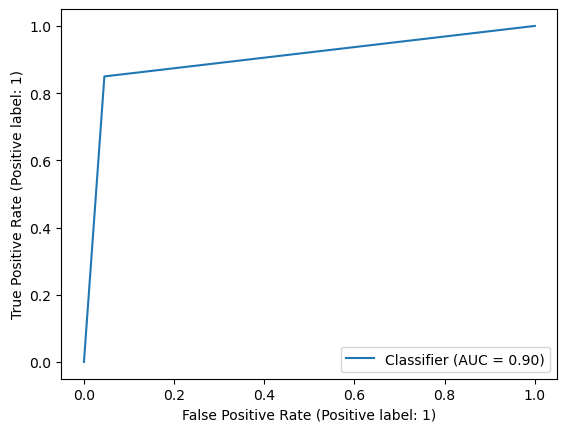

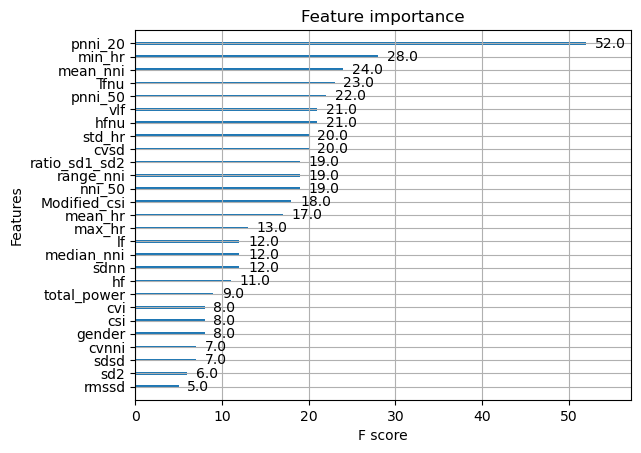

In [ ]:
y_pred_train = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_all.best_estimator_)
plt.show()